# Ohio Clinic Dataset - Advanced ML Pipeline

In [ ]:
!pip install ydata-profiling optuna-integration

## Mount GDrive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import joblib

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution ,
    CategoricalDistribution,
    FloatDistribution,
)

In [ ]:
from sklearn import set_config

# Set sklearn to show diagrams for pipelines
set_config(display='diagram')

## Constants

In [ ]:
# Set the verbose parameter to 1 to see the progress of the optimization
VERBOSE = 1

In [ ]:
# Base folder
BASE_FOLDER = "./Ohio/"
BASE_URL = "https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/"

# Define the train and test data paths
TRAIN_DATA_PATH =  BASE_URL + "mldm_ohio_clinic_train.csv"
TEST_DATA_PATH = BASE_URL + "mldm_ohio_clinic_test.csv"

# Define the random state
RANDOM_STATE = 3993

In [ ]:
# Define the optuna search hyperparameters
N_TRIALS = 20
N_JOBS = 8
CROSS_VALIDATION = 3

## Load Data

In [ ]:
# Load the train and test data from the CSV files using pandas
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

### Features Exploration

In [ ]:
# Print the first few rows of the train data to explore the columns and data
train_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,5.816289e+11,5760331,F,2016-06-01T14:40:47Z,2016-06-01T00:00:00Z,NaN,DA PENHA,0.0,0.0,0.0,0.0,0.0,0.0,No
1,9.731556e+11,5676727,M,2016-05-09T16:20:41Z,2016-05-11T00:00:00Z,32.0,TABUAZEIRO,0.0,0.0,0.0,0.0,0.0,0.0,No
2,3.958823e+13,5638275,M,2016-04-29T07:52:18Z,2016-05-03T00:00:00Z,58.0,CARATOÍRA,0.0,1.0,0.0,0.0,0.0,NaN,No
3,6.737886e+14,5696894,F,2016-05-13T14:34:40Z,2016-05-16T00:00:00Z,28.0,CONSOLAÇÃO,NaN,0.0,0.0,NaN,0.0,0.0,No
4,7.759954e+12,5691063,M,2016-05-12T11:15:06Z,2016-05-13T00:00:00Z,9.0,SÃO CRISTÓVÃO,0.0,0.0,0.0,0.0,0.0,0.0,No


In [ ]:
# Print the length of the train and test data
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 114949
Test data length: 22105


In [ ]:
# Print the frquency of each value in the target column
train_data.nunique()

PatientId         54081
AppointmentID     88422
Gender                2
ScheduledDay      83768
AppointmentDay       27
Age                 104
Neighbourhood        81
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handcap               5
SMS_received          2
No-show               2
dtype: int64

In [ ]:
train_data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age               float64
Neighbourhood      object
Scholarship       float64
Hipertension      float64
Diabetes          float64
Alcoholism        float64
Handcap           float64
SMS_received      float64
No-show            object
dtype: object

### Dataset Profiling (Pandas Profiling)

In [ ]:
# Profile the train data using the ydata_profiling library
profile = ProfileReport(train_data, title="Profiling Report Train Data", explorative=True)

In [ ]:
# Show the profile report in the notebook cell
# profile.to_notebook_iframe()

In [ ]:
# Save the profile report to an HTML file
profile.to_file( BASE_FOLDER + "profiling_report_train_data.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Visualisation

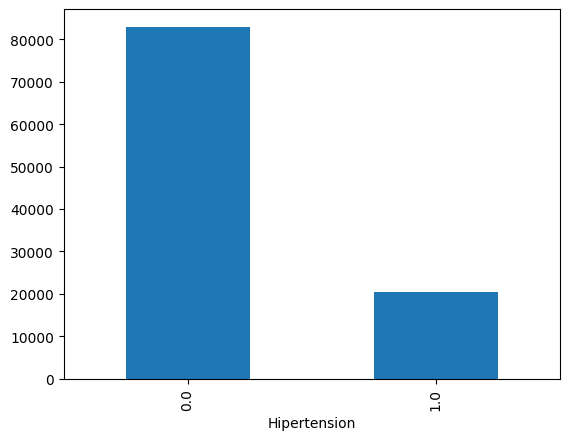

In [ ]:
# Print the bar chart of the Hipertension column
train_data["Hipertension"].value_counts().plot(kind="bar")
#sns.barplot(x=train_data["Hipertension"].value_counts().index, y=train_data["Hipertension"].value_counts().values)
plt.show()

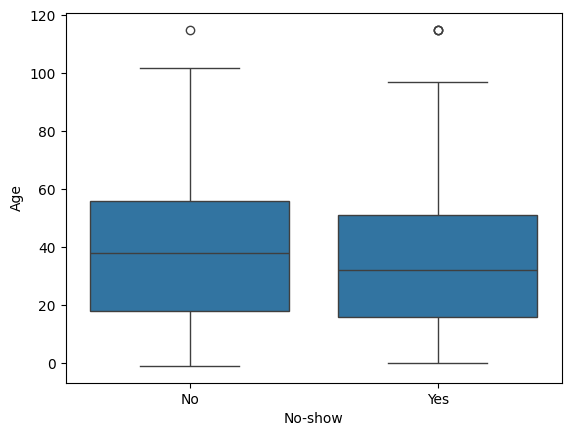

In [ ]:
# Plotting Box Plot of Patients’ Age by No-Shows
sns.boxplot(x=train_data["No-show"], y=train_data["Age"])
plt.show()

### Data Issues Identification

In [ ]:
# Count the number of missing values in each column of the train data
train_data.isnull().sum()

PatientId             0
AppointmentID         0
Gender            11462
ScheduledDay          0
AppointmentDay        0
Age               11528
Neighbourhood     11466
Scholarship       11451
Hipertension      11554
Diabetes          11456
Alcoholism        11512
Handcap           11472
SMS_received      11612
No-show               0
dtype: int64

## Data Preprocessing

### Duplicates removal

In [ ]:
# Remove duplicates from the train data
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [ ]:
train_data.shape, test_data.shape

((88422, 14), (22105, 14))

### X and y split

In [ ]:
# Divide the train and test data into features and target
X_train = train_data.drop(columns=["No-show"])
y_train = train_data["No-show"]

X_test = test_data.drop(columns=["No-show"])
y_test = test_data["No-show"]

### Convert the target column to binary values

In [ ]:
y_train = y_train.map({"No": 0, "Yes": 1})
y_test = y_test.map({"No": 0, "Yes": 1})

In [ ]:
y_train.value_counts()

No-show
0    70539
1    17883
Name: count, dtype: int64

## Classification Pipeline Definition

### In-Pipeline Columns Selection and Transformation

In [ ]:
# Define the column transformation for the numerical columns considering that
# 1) there are missing values and they have to be imputed
# 2) the age column has a to be always positive
# 3) the columns have to be scaled

# Define the numerical columns to be transformed
numerical_columns = [
    "Age",
]

# Create the numerical pipeline with the SimpleImputer and MinMaxScaler
numerical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("abs_transformer", FunctionTransformer(np.abs, validate=True)),
        ("scaler", MinMaxScaler()),
    ]
)

In [ ]:
# Define the column transformation for logical columns considering that
# 1) there are missing values and they have to be imputed

# Define the logical columns to be transformed
logical_columns = [
    "Scholarship",
    "Hipertension",
    "Diabetes",
    "Alcoholism",
    "SMS_received",
]

# Create the logical pipeline with the SimpleImputer
logical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

In [ ]:
# Define the column transformation for the string columns considering that
# 1) there are missing values and they have to be imputed
# 2) the columns have to be encoded using numerical encoding

# Define the categorical columns in the string format to be transformed
categorical_columns = [
    "Gender",
    "Neighbourhood",
]

# Create the string pipeline with the SimpleImputer and OneHotEncoder
categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ]
)

### Preprocessor

In [ ]:
# Define the preprocessor with the ColumnTransformer and the defined pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_columns),
        ("log", logical_pipeline, logical_columns),
        ("cat", categorical_pipeline, categorical_columns),
    ]
)

In [ ]:
# Show the preprocessor diagram
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('abs_transformer',
                                                  FunctionTransformer(func=<ufunc 'absolute'>,
                                                                      validate=True)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age']),
                                ('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Scholarship', 'Hipertension', 'Diabetes',
                                  'Alcoholism', 'SMS_received']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                 ['Gender', 'Neighbourhood'])])

In [ ]:
# Show the preprocessor parameters
preprocessor.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num',
   Pipeline(steps=[('imputer', SimpleImputer()),
                   ('abs_transformer',
                    FunctionTransformer(func=<ufunc 'absolute'>, validate=True)),
                   ('scaler', MinMaxScaler())]),
   ['Age']),
  ('log',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))]),
   ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']),
  ('cat',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                   ('one_hot_encoder',
                    OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
   ['Gender', 'Neighbourhood'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'num': Pipeline(steps=[('imputer', SimpleImputer()),
                 ('abs_transformer',
                  FunctionTransformer(func=<ufunc 'absolute'>, validate=True)),
                 ('scaler

###  Classification Model

In [ ]:
# Define the classifier model to be used
classifier = RandomForestClassifier(n_estimators=100, random_state=3993)

In [ ]:
# Show the classifier diagram
classifier

RandomForestClassifier(random_state=3993)

In [ ]:
# Show the classifier parameters
classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3993,
 'verbose': 0,
 'warm_start': False}

### Classification Pipeline

In [ ]:
# Define the classification pipeline with the preprocessor and the classifier
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

In [ ]:
# Show the pipeline diagram
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('abs_transformer',
                                                                   FunctionTransformer(func=<ufunc 'absolute'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age']),
                                                 ('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Scholarship',
                                                   'Hipertension', 'Diabetes',
                                                   'Alcoholism',
                                                   'SMS_received']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['Gender',
                                                   'Neighbourhood'])])),
                ('classifier', RandomForestClassifier(random_state=3993))])

In [ ]:
# Show the pipeline parameters
pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('abs_transformer',
                                                     FunctionTransformer(func=<ufunc 'absolute'>,
                                                                         validate=True)),
                                                    ('scaler', MinMaxScaler())]),
                                    ['Age']),
                                   ('log',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    ['Scholarship', 'Hipertension', 'Diabetes',
                                     'Alcoholism', 'SMS_received']),
                                   ('cat',
                                    Pipeline(s

In [ ]:
# Define the scoring metrics for the classification
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

### Hyperparameter Tuning (Optuna)

In [ ]:
# # Define the parameter search space for the classifier and the preprocessor for the OptunaSearchCV
# optuna_param_distributions = {
#     "preprocessor__num__imputer__strategy": CategoricalDistribution(
#         ["mean", "median"]
#     ),
#     "preprocessor__log__imputer__strategy": CategoricalDistribution(
#         ["most_frequent", "constant"]
#     ),
#     "preprocessor__cat__imputer__strategy": CategoricalDistribution(
#         ["most_frequent", "constant"]
#     ),
#     "classifier__n_estimators": IntDistribution(100, 300),
#     "classifier__max_depth": IntDistribution(5, 15),
#     "classifier__min_samples_split": IntDistribution(2, 10),
#     "classifier__min_samples_leaf": IntDistribution(1, 4),
#     "classifier__random_state": CategoricalDistribution(
#         [RANDOM_STATE]
#     ),
#     "classifier_ccp_alpha": FloatDistribution(1e-6, 1e-2, log=True),
# }

In [ ]:
# Define the parameter search space for the classifier and the preprocessor for the OptunaSearchCV
optuna_param_distributions = {
    "preprocessor__num__imputer__strategy": CategoricalDistribution(["mean", "median"]),
    "classifier__n_estimators": IntDistribution(3, 20),
    "classifier__max_depth": IntDistribution(5, 15),
}

In [ ]:
# Create the optuna study for the optimization
study = optuna.create_study(
    study_name="ohio_clinic_classification",
    storage="sqlite:///ohio_clinic.sqlite3",
    load_if_exists=True,
    direction="maximize",
)

[I 2024-05-31 13:32:27,503] A new study created in RDB with name: ohio_clinic_classification


In [ ]:
# Define the OptunaSearchCV with the pipeline, the parameter search space, and the number of trials
optuna_search = OptunaSearchCV(
    pipeline,
    optuna_param_distributions,
    n_trials=N_TRIALS,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    cv=CROSS_VALIDATION,
    study=study,
    verbose=VERBOSE,
)

<ipython-input-43-0e4d84aa6ed1>:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


In [ ]:
# Display the OptunaSearchCV diagram
optuna_search

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('num',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer()),
                                                                                           ('abs_transformer',
                                                                                            FunctionTransformer(func=<ufunc 'absolute'>,
                                                                                                                validate=True)),
                                                                                           ('scaler',
                                                                                            MinMaxScaler())]),
                                                                           ['Age']),
                                                                          ('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['Scholarship...
               n_jobs=8, n_trials=20,
               param_distributions={'classifier__max_depth': IntDistribution(high=15, log=False, low=5, step=1),
                                    'classifier__n_estimators': IntDistribution(high=20, log=False, low=3, step=1),
                                    'preprocessor__num__imputer__strategy': CategoricalDistribution(choices=('mean', 'median'))},
               random_state=3993,
               study=<optuna.study.study.Study object at 0x7e44ddbf3dc0>,
               verbose=1)

In [ ]:
# Display the OptunaSearchCV parameters
optuna_search.get_params()

{'callbacks': None,
 'cv': 3,
 'enable_pruning': False,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('abs_transformer',
                                                     FunctionTransformer(func=<ufunc 'absolute'>,
                                                                         validate=True)),
                                                    ('scaler', MinMaxScaler())]),
                                    ['Age']),
                                   ('log',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    ['Scholarship', 'Hipertension', 'Diabetes',
                                     'Alcoholism', 'SMS_rec

## Run Experiment

###   Pipeline Training

In [ ]:
# Fit the OptunaSearchCV with the train data
optuna_search.fit(X_train, y_train)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 88422 samples...
[I 2024-05-31 13:32:34,736] Trial 0 finished with value: 0.7976634774151229 and parameters: {'preprocessor__num__imputer__strategy': 'mean', 'classifier__n_estimators': 5, 'classifier__max_depth': 7}. Best is trial 0 with value: 0.7976634774151229.
[I 2024-05-31 13:32:38,230] Trial 7 finished with value: 0.7977426432335845 and parameters: {'preprocessor__num__imputer__strategy': 'median', 'classifier__n_estimators': 9, 'classifier__max_depth': 8}. Best is trial 7 with value: 0.7977426432335845.
[I 2024-05-31 13:32:38,973] Trial 3 finished with value: 0.7977539526362217 and parameters: {'preprocessor__num__imputer__strategy': 'median', 'classifier__n_estimators': 15, 'classifier__max_depth': 6}. Best is trial 3 with value: 0.7977539526362217.
[I 2024-05-31 13:32:39,920] Trial 2 finished with value: 0.7977539526362217 and parameters: {'preprocessor__num__imputer__strategy': 'mean', 'classifier__n_es

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('num',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer()),
                                                                                           ('abs_transformer',
                                                                                            FunctionTransformer(func=<ufunc 'absolute'>,
                                                                                                                validate=True)),
                                                                                           ('scaler',
                                                                                            MinMaxScaler())]),
                                                                           ['Age']),
                                                                          ('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['Scholarship...
               n_jobs=8, n_trials=20,
               param_distributions={'classifier__max_depth': IntDistribution(high=15, log=False, low=5, step=1),
                                    'classifier__n_estimators': IntDistribution(high=20, log=False, low=3, step=1),
                                    'preprocessor__num__imputer__strategy': CategoricalDistribution(choices=('mean', 'median'))},
               random_state=3993,
               study=<optuna.study.study.Study object at 0x7e44ddbf3dc0>,
               verbose=1)

In [ ]:
# Show the best parameters found by the OptunaSearchCV
optuna_search.best_params_

{'preprocessor__num__imputer__strategy': 'median',
 'classifier__n_estimators': 19,
 'classifier__max_depth': 6}

In [ ]:
# Show the best score found by the OptunaSearchCV
optuna_search.best_score_

0.7977539526362217

In [ ]:
# Show the best estimator found by the OptunaSearchCV
optuna_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('abs_transformer',
                                                                   FunctionTransformer(func=<ufunc 'absolute'>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age']),
                                                 ('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Scholarship',
                                                   'Hipertension', 'Diabetes',
                                                   'Alcoholism',
                                                   'SMS_received']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['Gender',
                                                   'Neighbourhood'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=6, n_estimators=19,
                                        random_state=3993))])

### Pipeline Saving

In [ ]:
# Save the classification pipeline to a file using joblib
joblib.dump(optuna_search.best_estimator_, BASE_FOLDER + "classification_pipeline.joblib")

['/content/drive/MyDrive/Colab Notebooks/mldm_2024/data/classification_pipeline.joblib']

### Pipeline Reloading

In [ ]:
# Load the classification pipeline from a file using joblib
classification_pipeline = joblib.load( BASE_FOLDER + "classification_pipeline.joblib")

### Pipeline Evaluation

In [ ]:
# Evaluate the classification pipeline on the test data
classification_pipeline.score(X_test, y_test)

0.7993214204931011

In [ ]:
# Predict the target values using the classification pipeline
y_pred = classification_pipeline.predict(X_test)

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17669
           1       0.00      0.00      0.00      4436

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Exercises

1. Find the best scaler between MinMaxScaler, StandardScaler, RobustScaler
1. Use IterativeImputer instead of SimpleImputer
1. Transform the data using PCA in the Pipeline and find the best N components
1. Change the classification model using XGBoost